# Проект для "Викишоп"

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Цель: обучить модель классифицировать комментарии на позитивные и негативные на основе набора данных с разметкой о токсичности правок

## Подключение необходимых библиотек

In [2]:
import time
print ("Начало выполнения кода данного ноутбука : ", time.strftime('%X'))

!pip install scikit-learn==1.4 -q
!pip install pandas==1.5.0 -q
!pip install nltk -q
!pip install spacy -q
!python -m spacy download en_core_web_sm -q
!pip install tqdm -q
!pip install catboost -q
!pip install lightgbm -q

import pandas as pd
import os
import platform
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# загружаем pipeline, нужные модели и метрики
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import f1_score
import spacy
import re
from tqdm import tqdm

# загружаем классы для подготовки данных, нужные модели и метрики
from numpy.random import RandomState
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

RANDOM_STATE = 77

Начало выполнения кода данного ноутбука :  23:40:55
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Загрузка данных из файла csv

In [3]:
data= [{id: "1", "name": "name"}]
df= pd.DataFrame(data)
df.head()

,<built-in function id>,name
0,1,name


In [2]:
datasets_path='/datasets/'
if platform.system()=='Windows':
    cwd = os.getcwd()
    datasets_path= os.getcwd()+'\\datasets\\'
data= pd.read_csv(datasets_path+'toxic_comments.csv', sep=',', index_col=[0])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


## Подготовка данных

In [3]:
data= data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


### Очистка от спец.символов

In [4]:
def clear_text(text):
    no_clear_text = re.sub(r'[^a-zA-z]\'', ' ', text)
    clear_text = " ".join(no_clear_text.split()).lower() 
    return clear_text
data['lemm_text']=data['text'].apply(clear_text) 
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww! he matches this background colour i'm s...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man, i'm really not trying to edit war. it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,""" more i can't make any real suggestions on im..."
4,"You, sir, are my hero. Any chance you remember...",0,"you, sir, are my hero. any chance you remember..."


### Анализ сбалансированности классов целевого признака

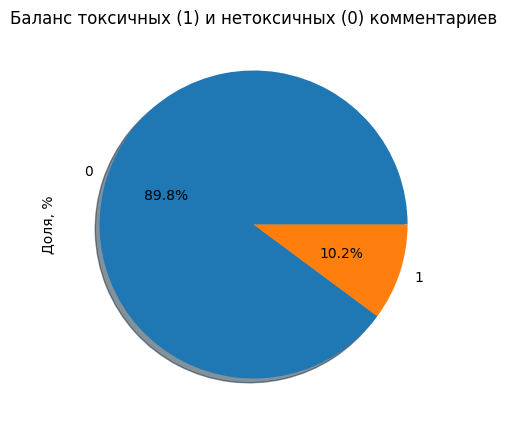

In [5]:
def plot_balance(df):
    fig = plt.figure(figsize=(5, 5))     
    ax= df['toxic'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%', 
    shadow=True,
    ylabel='Доля, %',
    title='Баланс токсичных (1) и нетоксичных (0) комментариев')
    plt.show()
plot_balance(data)

Вывод: классы не сбалансированы, при этом доля нетоксичных комментариев составляет почти 90%. Несбаланиросанность классов модели будем учитывать в модели.

### Лемматизация  

Используем библиотеки NLTK и spacy, тк исходный язык текста - английский 

In [6]:
# загружаем модель английского языка spacy
disabled_pipes = [ "parser",  "ner"]
nlp = spacy.load('en_core_web_sm', disable=disabled_pipes)

lemm_texts = []

for doc in tqdm(nlp.pipe(data['lemm_text'].values, disable = ['ner', 'parser']), total=data.shape[0]):
    lemm_text = " ".join([i.lemma_ for i in doc])    
    lemm_texts.append(lemm_text) 

data['lemm_text']= lemm_texts
data=data.drop_duplicates()
data.info()
data.head()

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [11:52<00:00, 223.72it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       159292 non-null  object
 1   toxic      159292 non-null  int64 
 2   lemm_text  159292 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d'aww ! he match this background colour I be s...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man , I be really not try to edit war . it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,""" more I can not make any real suggestion on i..."
4,"You, sir, are my hero. Any chance you remember...",0,"you , sir , be my hero . any chance you rememb..."


### Подготовка тренировочной, валидационной и тестовой выборки

In [7]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(data['lemm_text'], 
                                                                                        data.toxic, test_size=0.2, 
                                                                                        random_state=RANDOM_STATE)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, 
                                                                            target_valid_test, 
                                                                            test_size=0.5, 
                                                                            random_state=RANDOM_STATE)
print('Размер выборки признаков для обучения:', len(features_train))
print('Размер выборки признаков для валидации:', len(features_valid))
print('Размер выборки признаков для тестов:', len(features_test))
print('Размер выборки целевых признаков для обучения:', len(target_train))
print('Размер выборки целевых признаков для валидации:', len(target_valid))
print('Размер выборки целевых признаков для тестов:', len(target_test))

Размер выборки признаков для обучения: 127433
Размер выборки признаков для валидации: 15929
Размер выборки признаков для тестов: 15930
Размер выборки целевых признаков для обучения: 127433
Размер выборки целевых признаков для валидации: 15929
Размер выборки целевых признаков для тестов: 15930


### Создание мешка слов для тренировочной выборки

Не будем удалять стоп-слова тк с ними метрика выше

In [8]:
count_tf_idf = TfidfVectorizer() 

In [9]:
tf_idf_train = count_tf_idf.fit_transform(features_train) 
print("Размер матрицы:", tf_idf_train.shape)

Размер матрицы: (127433, 151348)


In [10]:
features_train= tf_idf_train
print('Используем для обучения объекты типа:', type(features_train))

Используем для обучения объекты типа: <class 'scipy.sparse._csr.csr_matrix'>


### Обучение моделей, расчет метрик

### Создание мешка слов на валидационной выборке

In [11]:
features_valid = count_tf_idf.transform(features_valid) 
print("Размер матрицы:", features_valid.shape)

Размер матрицы: (15929, 151348)


#### Обучение модели логистической регрессии

In [12]:
model1= LogisticRegression(class_weight='balanced', penalty='l2', solver='saga')
param_search = {
    'C': range(1, 15)
} 
gsearch = GridSearchCV(estimator=model1, 
                       cv=5, 
                       param_grid=param_search,  
                       scoring='f1')

gsearch.fit(features_train, target_train)
print(f'Метрика f1 модели логистической регрессии на кросс-валидации равна {round(gsearch.best_score_,2)}')
print(f'Параметры лучшей модели: {gsearch.best_params_}')
model1_pred= gsearch.best_estimator_.predict(features_valid)
score_1 = f1_score(target_valid.tolist(), model1_pred) 
print(f'Метрика f1 модели логистической регрессии на валидационной выборке: {round(score_1,2)}')

Метрика f1 модели логистической регрессии на кросс-валидации равна 0.77
Параметры лучшей модели: {'C': 8}
Метрика f1 модели логистической регрессии на валидационной выборке: 0.77


#### Обучение модели catboost

In [13]:
model2= CatBoostClassifier(random_state=RANDOM_STATE, auto_class_weights = 'Balanced', thread_count=-1)
model2.fit(features_train, target_train, verbose=100)
model2_pred= model2.predict(features_valid)
score_2 = f1_score(target_valid.tolist(), model2_pred) 
print(f'Метрика f1 модели CatBoostClassifier на валидационной выборке: {round(score_2,2)}')

Learning rate set to 0.081637
0:	learn: 0.6499472	total: 894ms	remaining: 14m 53s
100:	learn: 0.3390197	total: 1m 8s	remaining: 10m 8s
200:	learn: 0.2861327	total: 2m 14s	remaining: 8m 53s
300:	learn: 0.2545731	total: 3m 19s	remaining: 7m 43s
400:	learn: 0.2336136	total: 4m 24s	remaining: 6m 35s
500:	learn: 0.2180140	total: 5m 29s	remaining: 5m 28s
600:	learn: 0.2056379	total: 6m 35s	remaining: 4m 22s
700:	learn: 0.1949109	total: 7m 39s	remaining: 3m 15s
800:	learn: 0.1860684	total: 8m 43s	remaining: 2m 10s
900:	learn: 0.1779897	total: 9m 47s	remaining: 1m 4s
999:	learn: 0.1707780	total: 10m 51s	remaining: 0us
Метрика f1 модели CatBoostClassifier на валидационной выборке: 0.75


#### Обучение модели LGBMClassifier

In [14]:
model3= LGBMClassifier(random_state= RANDOM_STATE, class_weight= 'balanced', n_jobs= -1, verbosity = -1)
model3.fit(features_train, target_train)
model3_pred= model3.predict(features_valid)
score_3= f1_score(target_valid.tolist(), model3_pred) 
print(f'Метрика f1 модели LGBMClassifier на валидационной выборке: {round(score_3,2)}')

Метрика f1 модели LGBMClassifier на валидационной выборке: 0.71


### Создание мешка слов на тестовой выборке 

In [15]:
features_test = count_tf_idf.transform(features_test) 
print("Размер матрицы:", features_test.shape)

Размер матрицы: (15930, 151348)


### Предсказание с использованием лучшей модели и расчет метрики на тестовой выборке

Выберем лучшую модель по показателям метрики

In [16]:
best_score=score_1
best_model= gsearch.best_estimator_
best_model_name='Модель логистической регрессии'
if score_2> best_score:
    best_score= score_2
    best_model= model2
    best_model_name= 'CatBoostClassifier'
if score_3> best_score:
    best_score= score_3
    best_model= model3
    best_model_name= 'LGBMClassifier'

Расчет метрики на тестовой выборке

In [17]:
test_pred=best_model.predict(features_test)
score_test = f1_score(target_test.tolist(), test_pred) 
print(f'Метрика f1 лучшей модели на тестовой выборке ({best_model_name}): {round(score_test, 2)}')

Метрика f1 лучшей модели на тестовой выборке (Модель логистической регрессии): 0.78


In [18]:
print ("Окончание выполнения кода данного ноутбука : ", time.strftime('%X'))

Окончание выполнения кода данного ноутбука :  14:18:56


### Выводы

**По результатам моделирования выбрана модель логистической регресиии. Метрика f1 модели на тестовой выборке составляет 0.78, что соответствует заданному в проекте критерию качества**